In [112]:
import numpy as np
import matplotlib.pyplot as plt

## TODO LISTE
1. heatmap plots
2. er 5D virkelig nødvendig??
3. beta???
4. clean up kode
5. Vinkel??

In [113]:
def single_simulation(P=[0,1/6,2/6,3/6,4/6,5/6,1], WTP=1, N=4, c_I=0.15, c_E=0.1, k_i=0, k_e=0.05, b_E=0.005, b_I=100, alpha=0.3, delta=0.985,sigma=0.95,
                      p_bar=1.1, beta=0.00014, episodes=50000):

        p1s = []
        p2s = []
        period_exited = []
        P2 = list(P)
        P2.append(p_bar)

        #profit function (takes into account demand)
        def profit(p1,p2,c,k,WTP=WTP):
            if p1 == 1.1:#hvis spilleren folder
                return 0
            elif p1 <= WTP and p1<p2:
                return p1 - c - k
            elif p1 == p2 and p1 <= WTP:
                return (p1 - c)/2 - k
            else:
                return -k

        def create_q_table():
            Q = {}
            for own_price in P2:          # State dimension 1: own previous price
                Q[own_price] = {}
                for opp_price in P2:      # State dimension 2: opponent's previous price
                    Q[own_price][opp_price] = {}
                    for exit_state in [0, 1]:   # State dimension 3: opponent exit state
                        Q[own_price][opp_price][exit_state] = {}
                        for period in range(N):  # State dimension 4: current period
                            Q[own_price][opp_price][exit_state][period] = {p: 0.0 for p in P2}  # Dictionary of possible actions
            return Q
        
        Q_E = create_q_table()
        Q_I = create_q_table()


        #find the p of the maximum Q
        def argmax_Q_value(Q,s):
            p1,p2,chi1,t = s
            max_value = float('-inf')
            best_price = None
            for own_price in P:
                value = Q[p1][p2][chi1][t][own_price]
                if value > max_value:
                    max_value = value
                    best_price = own_price
            return best_price

        #epsilon-greedy exploration policy
        def epsilon(g,beta):
            return np.exp(-beta*g)

        def explore_exploit(Q, s, g):
            bar = epsilon(g,beta) #becomes smaller over each period (game)
            random_number = np.random.uniform(0, 1)
            if bar < random_number:
                return argmax_Q_value(Q,s)
            else:
                return np.random.choice(P)

        #s_1_I = ( p_I_n-1 , p_E_n-1 , phi_E_n-1 , t )
        #s_1_E = ( p_I_n-1 , p_E_n-1 , phi_E_n-1 , t )

        # t refererer til en periode i en episode t = {1,2,..,N}
        # g refererer til en episode (hver episode indeholder N perioder)

        def Q_up_var(Q,c,k,s,s_new,n):
            p1,p2,phi,t = s
            p1_new,p2_new,phi_new,t_new = s_new
            if not(n%N):
                discount = sigma
            else: discount = delta

            prev = (1-alpha)*Q[p1][p2][phi][t][p1_new]

            new = (alpha)*(profit(p1,p2,c,k)+discount*max(Q[p1_new][p2_new][phi_new][t_new][x] for x in P))

            Q[p1][p2][phi][t][p1_new]=prev+new
            return Q

        #if n is a multiple of N, ie we are at the end of a N-periode game:
        #1. move back to base states s_0
        #2. then we reset the acc_profits and use the ALGORITHMIC DISCOUNT RARE, instead of the other
        s_list_E = [] #list of states for E
        s_list_I = [] 

        def fun(episodes, k_I=k_i, k_E=k_e):
            g=0

            while g < episodes:
                #initate turn 0
                p_E, p_I = [WTP],[WTP] #the pricelist (contains the start price)
                p_EXIT = []
                phi_E, phi_I = 1,1 #indicates whether OPPONENT was active
                acc_profit_E, acc_profit_I = 0,0 #the initial acc. profit

                s_E=[1,1,1,1] #list version of values [ p_E , p_I , phi_E , t+1]
                s_I=[1,1,1,1]

                s_list_E.append(s_E) #append the state to the state list
                s_list_I.append(s_I)

                if g>0:
                    Q_up_var(Q_E,c_E,k_E,                #E
                            s_list_E[-2], s_list_E[-1], 4*g)

                    Q_up_var(Q_I,c_I,k_I,                #I
                            s_list_I[-2], s_list_I[-1], 4*g)
                T = 1

                for t in range(1,N): #starts in 1, since round 0 has been initiated above

                    T=T+1
                    if T==4:
                        T=0

                    if phi_I==1:  #checks if the OPPONENT hasnt exited
                        p_E_new = explore_exploit(Q_E,s_E,g) #if the opponent hasnt, the opponent will explore-exploit
                    else:
                        p_E_new = 1.1 #if OPPONENT has exited, opponent will set its price to 1.1, indicating exit
                    #I
                    if phi_E==1:
                        p_I_new = explore_exploit(Q_I,s_I,g)
                    else:
                        p_I_new = 1.1

                    #append to price list (only for a single game/episode -ie. 4 periods)
                    p_E.append(p_E_new)
                    p_I.append(p_I_new)

                    s_E_new=[p_E_new, p_I_new, phi_E, T]

                    s_I_new=[p_I_new, p_E_new, phi_I, T]

                    #append the state to the state list
                    s_list_E.append(s_E_new)
                    s_list_I.append(s_I_new)

                    Q_up_var(Q_E,c_E,k_E,                #E
                            s_list_E[-2], s_list_E[-1], 4*g+t)

                    Q_up_var(Q_I,c_I,k_I,                #I
                            s_list_I[-2], s_list_I[-1], 4*g+t)

                    #payoff for both players
                    acc_profit_E =+ profit(p_E_new,p_I_new,c_E, k_E) #E
                    acc_profit_I =+ profit(p_I_new,p_E_new,c_I, k_I) #I

                    #checks for exit
                    if -b_E > acc_profit_E: #E

                        phi_I = 0 #

                        if p_E_new != 1.1:
                            p_EXIT.append(t)

                    if -b_I > acc_profit_I: #I
                        phi_E = 0


                    #set new values for s
                    s_E = s_E_new
                    s_I = s_I_new
                p1s.append(p_E)
                p2s.append(p_I)
                period_exited.append(p_EXIT)
                g=g+1

            return p1s, p2s, Q_E, Q_I, period_exited


        p1s, p2s, Q_E, Q_I, period_exited = fun(episodes)
        return p1s, p2s, Q_E, Q_I, period_exited



[1, 0.16666666666666666, 1.1, 1.1]
[1, 0.16666666666666666, 1, 1]


Text(0.5, 1.0, 'Period exited')

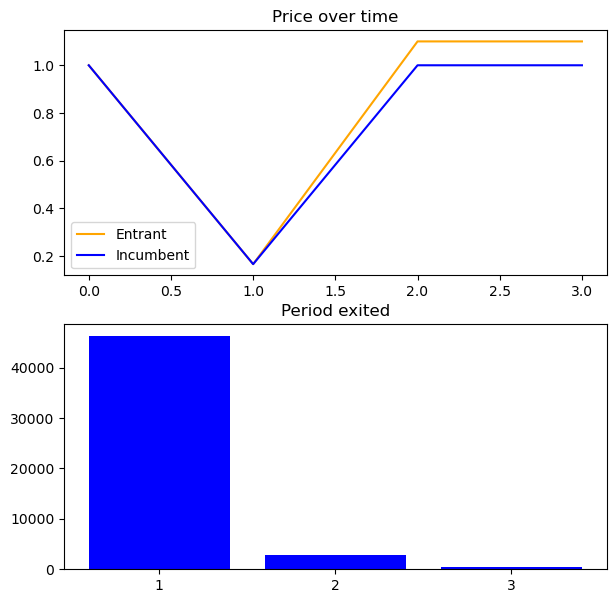

In [114]:
p1s, p2s, Q_E,Q_I, period_exited = single_simulation()
exit_periods = [p for sublist in period_exited for p in sublist]
unique, counts = np.unique(exit_periods, return_counts=True)
p1 = p1s[-2]
p2 = p2s[-2]
print(p1)
print(p2)
fig, ax = plt.subplots(2, figsize=(7, 7))
ax[0].plot(p1, label="Entrant", color="orange")
ax[0].plot(p2, label="Incumbent", color="blue")
ax[0].set_title("Price over time")
ax[0].legend()
ax[1].bar(unique, counts, color="blue")
ax[1].set_xticks(unique) 
ax[1].set_title("Period exited")

In [ ]:
def profit(p1,p2,c,k,WTP=1):
    if p1 == 1.1:#hvis spilleren folder
        return 0
    elif p1 <= WTP and p1<p2:
        return p1 - c - k
    elif p1 == p2 and p1 <= WTP:
        return (p1 - c)/2 - k
    else:
        return -k
    # c_I=0.15, c_E=0.1, k_i=0, k_e=0.05,
print(profit(1, 1, 0.15, 0))
print(profit(1, 1, 0.1, 0.05))
#make a dataframe with all possible profit combinations of p1=p2=[0,1/6,2/6,3/6,4/6,5/6,1]

def profit_matrix(P=[0,1/6,2/6,3/6,4/6,5/6,1], c_I=0.15, c_E=0.1, k_i=0, k_e=0.05):
    profit_list = []
    for p1 in P:
        for p2 in P:
            profit_list.append((profit(p1,p2,c_I,k_i), profit(p2,p1,c_E,k_e)))
    df = pd.DataFrame(profit_list, columns=["p1", "p2"])
    return df
profit_df = profit_matrix()
profit_df




0.425
0.4


,p1,p2
0,-0.075000,-0.100000
1,-0.150000,-0.050000
2,-0.150000,-0.050000
3,-0.150000,-0.050000
4,-0.150000,-0.050000
5,-0.150000,-0.050000
6,-0.150000,-0.050000
7,0.000000,-0.150000
8,0.008333,-0.016667
9,0.016667,-0.050000
